In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from keras.models import load_model
import pandas as pd
from scipy.stats import expon, lognorm

Using TensorFlow backend.


In [26]:
gen_model = load_model("../exp/gan_generator_0000_epoch_0010.h5")

In [3]:
def normalize_data(data, scaling_values=None):
    """
    Normalize each channel in the 4 dimensional data matrix independently.

    Args:
        data: 4-dimensional array with dimensions (example, y, x, channel/variable)
        scaling_values: pandas dataframe containing mean and std columns

    Returns:
        normalized data array, scaling_values
    """
    normed_data = np.zeros(data.shape, dtype=data.dtype)
    scale_cols = ["mean", "std"]
    if scaling_values is None:
        scaling_values = pd.DataFrame(np.zeros((data.shape[-1], len(scale_cols)), dtype=np.float32),
                                      columns=scale_cols)
    for i in range(data.shape[-1]):
        scaling_values.loc[i, ["mean", "std"]] = [data[:, :, i].mean(), data[:, :, i].std()]
        normed_data[:, :, i] = (data[:, :, i] - scaling_values.loc[i, "mean"]) / scaling_values.loc[i, "std"]
    return normed_data, scaling_values


def unnormalize_data(normed_data, scaling_values):
    """
    Re-scale normalized data back to original values

    Args:
        normed_data: normalized data
        scaling_values: pandas dataframe of mean and standard deviation from normalize_data

    Returns:
        Re-scaled data
    """
    data = np.zeros(normed_data.shape, dtype=normed_data.dtype)
    for i in range(normed_data.shape[-1]):
        data[:, :, i] = normed_data[:, :, i] * scaling_values.loc[i, "std"] + scaling_values.loc[i, "mean"]
    return data

def fit_condition_distributions(train_cond_data):
    """
    Calculate the scale parameter for the exponential distribution of correlated conditional variables
    for the Lorenz 96 model in time.

    Args:
        train_cond_data: array of conditioning values where the first column is the current X, and each
            other column is a lagged X value

    Returns:
        array of scale values
    """
    train_cond_exp_scale = np.zeros(train_cond_data.shape[1] - 1)
    for i in range(1, train_cond_data.shape[1]):
        train_cond_exp_scale[i - 1] = expon.fit(np.abs(train_cond_data[:, 0] - train_cond_data[:, i]), floc=0)[1]
    return train_cond_exp_scale


def generate_random_condition_data(batch_size, num_cond_inputs, train_cond_scale):
    """
    Generate correlated conditional random numbers to train the generator network.

    Args:
        batch_size: number of random samples
        num_cond_inputs: number of conditional inputs
        train_cond_scale: exponential distribution scale values

    Returns:

    """
    batch_cond_data = np.zeros((batch_size, num_cond_inputs, 1))
    batch_cond_data[:, 0, 0] = np.random.normal(size=batch_size)
    for t in range(1, train_cond_scale.size + 1):
        batch_cond_data[:, t , 0] = batch_cond_data[:, 0, 0] + \
                                    np.random.choice([-1, 1], size=batch_size) * expon.rvs(loc=0,
                                                                                           scale=train_cond_scale[t-1],
                                                                                           size=batch_size)
    return batch_cond_data

In [8]:
patches.shape

(1000, 1)

In [27]:
gan_samples = xr.open_dataset("../exp/gan_gen_patches_0000_epoch_0010.nc")

In [28]:
patches = gan_samples["gen_samples"][:, :, 0]

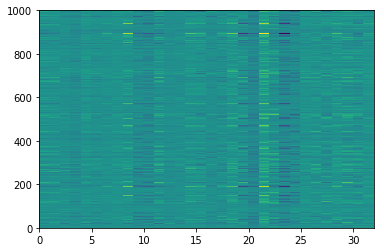

In [29]:
plt.pcolormesh(patches)

(array([  32.,   85.,  107.,  109.,  123.,  147.,  141.,  149.,   98.,    9.]),
 array([-0.24940473, -0.17612479, -0.10284485, -0.02956491,  0.04371504,
         0.11699498,  0.19027492,  0.26355486,  0.3368348 ,  0.41011474,
         0.48339468]),
 <a list of 10 Patch objects>)

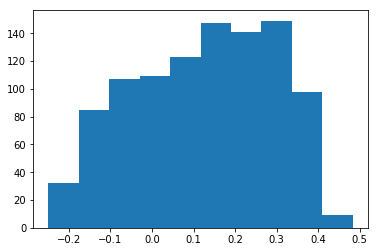

In [6]:
plt.hist(patches[:, 0])

In [7]:
gan_cond_x = gan_samples["gen_cond"].values

In [17]:
gan_samples.close()

(array([  32.,   85.,  107.,  109.,  123.,  147.,  141.,  149.,   98.,    9.]),
 array([-0.24940473, -0.17612479, -0.10284485, -0.02956491,  0.04371504,
         0.11699498,  0.19027492,  0.26355486,  0.3368348 ,  0.41011474,
         0.48339468]),
 <a list of 10 Patch objects>)

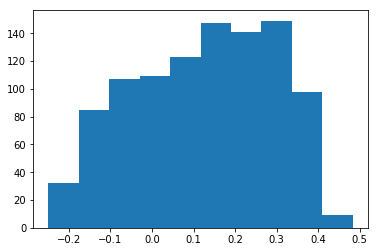

In [8]:
plt.hist(patches.mean(axis=1))

This is a cell!
$X_t=X_t -1$

In [9]:
gan_loss = pd.read_csv("../exp_mean/gan_loss_history_0000.csv", index_col="Time")

(0.65, 0.75)

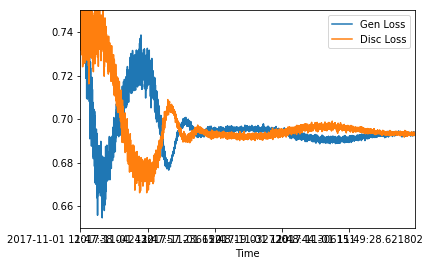

In [10]:
gan_loss[["Gen Loss", "Disc Loss"]].rolling(10).mean().plot()
plt.ylim(0.65, 0.75)

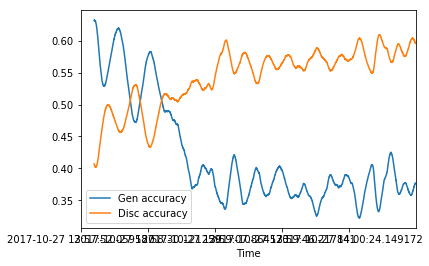

In [9]:
gan_loss[["Gen accuracy", "Disc accuracy"]].rolling(1000).mean().plot()

In [11]:
combined_data = pd.read_csv("../exp/lorenz_combined_output.csv")

In [12]:
y_cols = combined_data.columns[combined_data.columns.str.contains("Y")]
x_cols = combined_data.columns[combined_data.columns.str.contains("X")]
print(y_cols)
print(x_cols)

Index(['Y_0', 'Y_1', 'Y_2', 'Y_3', 'Y_4', 'Y_5', 'Y_6', 'Y_7', 'Y_8', 'Y_9',
       'Y_10', 'Y_11', 'Y_12', 'Y_13', 'Y_14', 'Y_15', 'Y_16', 'Y_17', 'Y_18',
       'Y_19', 'Y_20', 'Y_21', 'Y_22', 'Y_23', 'Y_24', 'Y_25', 'Y_26', 'Y_27',
       'Y_28', 'Y_29', 'Y_30', 'Y_31'],
      dtype='object')
Index(['X_t', 'X_t-1', 'X_t-2'], dtype='object')


In [30]:
x_norm, x_scaling = normalize_data(np.expand_dims(combined_data[x_cols].values, axis=-1))
y_norm, y_scaling = normalize_data(np.expand_dims(combined_data[y_cols].values, axis=-1))
gan_norm = gen_model.predict([x_norm[:,:,0] , np.random.normal(size=(x_norm.shape[0], 20))])
gan_y = unnormalize_data(gan_norm, y_scaling)

In [14]:
gan_y[:, 0]

(159680, 1, 1)

In [31]:
combined_data[y_cols].sum(axis=1)

0          4.926029
1         10.222297
2         11.664714
3          4.577420
4          4.263289
5         -2.209987
6        -10.027118
7         -1.809109
8         -1.971582
9         -0.954677
10         1.341776
11         5.403849
12         6.640046
13         7.226279
14         5.627506
15         1.915897
16        -0.060050
17         2.391930
18         6.699027
19         9.279217
20         7.474440
21         8.197982
22         8.629754
23         7.758522
24         2.818463
25        -4.876926
26        -3.061586
27        -1.882259
28         0.073738
29         5.744120
            ...    
159650     5.730738
159651    11.864333
159652     9.680757
159653     9.533498
159654     4.225074
159655     3.323181
159656    -4.679347
159657    -5.176614
159658    -3.246695
159659    -2.440437
159660    -0.754108
159661     3.140462
159662     6.842428
159663     8.621403
159664     5.728205
159665     3.229547
159666     6.398319
159667     9.459176
159668     8.312717


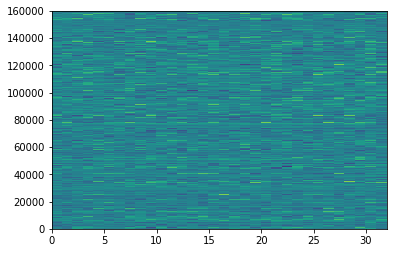

In [15]:
plt.pcolormesh(combined_data[y_cols])

In [1]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = axes[0].hist2d(combined_data["X_t"], combined_data[y_cols].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
                                                                                   np.linspace(-30, 30, 30)], cmin=1)
axes[0].set_title("Lorenz '96 Truth", fontsize=16)
_ = axes[1].hist2d(combined_data["X_t"], gan_y[:, 0, 0], bins=[np.linspace(-30, 30, 30), 
                                                                    np.linspace(-1, 1, 30)], cmin=1)
axes[1].set_title("Lorenz '96 GAN", fontsize=16)
axes[0].set_xlabel("X$_t$", fontsize=14)
axes[1].set_xlabel("X$_t$", fontsize=14)
axes[0].grid()
axes[1].grid()
axes[0].set_ylabel("$\overline{Y}$", fontsize=14)
plt.savefig("../exp/gan_x_ymean_hist.png", dpi=200, bbox_inches="tight")

NameError: name 'plt' is not defined

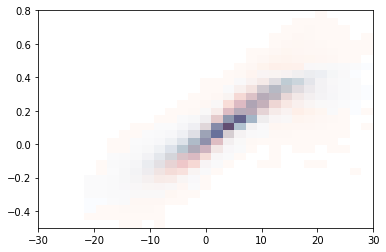

In [141]:
_ = plt.hist2d(combined_data["X_t"], combined_data[y_cols].mean(axis=1), bins=[np.linspace(-30, 30, 30), 
               np.linspace(-0.5, 0.8, 30)], cmin=1, cmap="Reds", alpha=0.6)

_ = plt.hist2d(combined_data["X_t"], gan_y[:, :, 0].mean(axis=1), bins=[np.linspace(-30, 30, 30), 
               np.linspace(-0.5, 0.8, 30)], cmap="Blues", cmin=1, alpha=0.6)

In [17]:
y_data = combined_data[y_cols].values

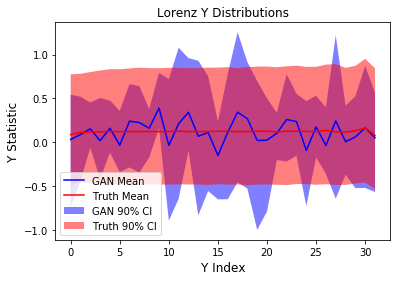

In [18]:
plt.fill_between(np.arange(32), np.percentile(gan_y[:, :, 0], 95, axis=0), 
                 np.percentile(gan_y[:, :, 0], 5, axis=0), alpha=0.5, label="GAN 90% CI", facecolor="blue")
plt.plot(gan_y[:, :, 0].mean(axis=0), label="GAN Mean", color="blue")
plt.fill_between(np.arange(32), np.percentile(y_data, 95, axis=0), 
                 np.percentile(y_data, 5, axis=0), alpha=0.5, facecolor="red", label="Truth 90% CI")
plt.plot(y_data.mean(axis=0), label="Truth Mean", color="red")
plt.legend(loc=3, fontsize=10)
plt.xlabel("Y Index", fontsize=12)
plt.ylabel("Y Statistic", fontsize=12)
plt.title("Lorenz Y Distributions")
plt.savefig("../exp/lorenz_y_dist.png", dpi=200, bbox_inches="tight")

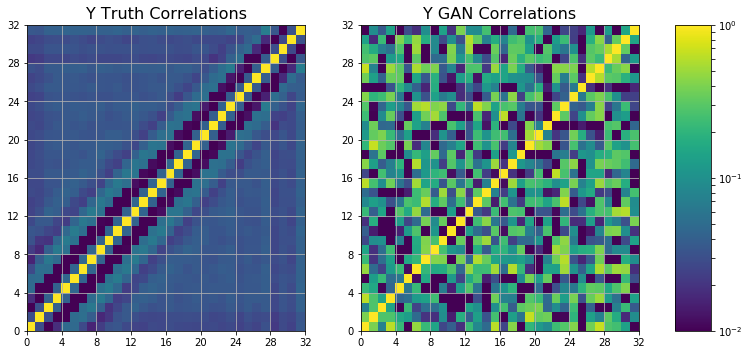

In [20]:
from matplotlib.colors import LogNorm
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(0.05, 0.05, 0.9, 0.9)
cax = fig.add_axes([0.95, 0.05, 0.05, .85])
pc = axes[0].pcolormesh(np.corrcoef(y_data.T) **2, vmin=0.01, vmax=1, norm=LogNorm(0.01, 1))
axes[1].pcolormesh(np.corrcoef(gan_y[:, :, 0].T)**2, vmin=0.01, vmax=1, norm=LogNorm(0.01, 1))
axes[0].set_title("Y Truth Correlations", fontsize=16)
axes[0].set_xticks(np.linspace(0, 32, 9))
axes[1].set_xticks(np.linspace(0, 32, 9))
axes[0].set_yticks(np.linspace(0, 32, 9))
axes[1].set_yticks(np.linspace(0, 32, 9))
axes[0].grid()
axes[1].grid()
axes[1].set_title("Y GAN Correlations", fontsize=16)
plt.colorbar(pc, cax=cax)
plt.savefig("../exp/y_gan_correlations.png", dpi=200, bbox_inches="tight")

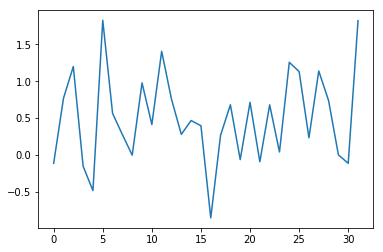

In [65]:
plt.plot(rand_y[20])

In [125]:
np.corrcoef(combined_data[x_cols].values.T)

array([[ 1.        ,  0.99849226,  0.9939843 ],
       [ 0.99849226,  1.        ,  0.99849224],
       [ 0.9939843 ,  0.99849224,  1.        ]])

(array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.25250501e-04,   1.37775551e-03,
          1.66583166e-02,   6.22494990e-02,   1.50425852e-01,
          2.78557114e-01,   4.17459920e-01,   5.49223447e-01,
          6.26377756e-01,   6.94138277e-01,   7.29083166e-01,
          7.65656313e-01,   7.74298597e-01,   7.59519038e-01,
          7.57765531e-01,   7.68787575e-01,   7.52379760e-01,
          6.43036072e-01,   5.89178357e-01,   5.88677355e-01,
          6.10345691e-01,   7.42109218e-01,   9.35621242e-01,
          1.23271543e+00,   1.36447896e+00,   1.31776052e+00,
          1.19739479e+00,   1.08817635e+00,   8.72494990e-01,
          3.97670341e-01,   1.93261523e-01,   8.19138277e-02,
          3.56963928e-02,   5.38577154e-03,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]),
 array([ -1.00000000e+00,  -9.50000000e-01,  -9.00000000e-01,
         -8.50000000e-01,  -8.00000000e-01,  -7.50000000e-01,
         -7.00000000e-01

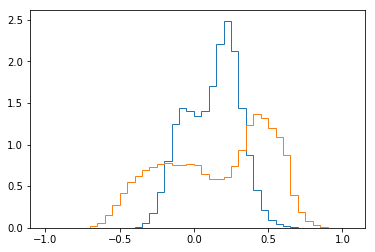

In [47]:
plt.hist(combined_data[y_cols].mean(axis=1), bins=np.arange(-1, 1.1, 0.05), normed=True, histtype="step")
plt.hist(gan_y[:, 0, 0], bins=np.arange(-1, 1.1, 0.05), normed=True, histtype="step")

(array([ 0.71562237,  0.77402373,  0.86717802,  0.94614325,  1.10242859,
         1.22190462,  1.33603405,  1.48717843,  1.57292973,  1.60706574,
         1.50774229,  1.41499928,  1.22663431,  1.07076025,  0.86059759,
         0.68354274,  0.5182093 ,  0.40222912,  0.29694215,  0.22661375,
         0.16122067]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ,  1.05]),
 <a list of 1 Patch objects>)

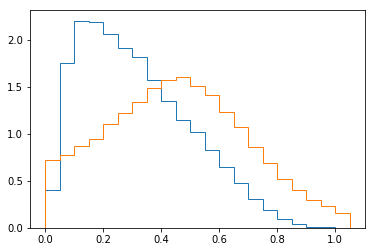

In [24]:
plt.hist(combined_data[y_cols].std(axis=1), bins=np.arange(0, 1.1, 0.05), normed=True, histtype="step")
plt.hist(gan_y[:, 0, 0], bins=np.arange(0, 1.1, 0.05), normed=True, histtype="step")

(array([  4.47340000e+04,   3.57560000e+04,   2.38510000e+04,
          1.61240000e+04,   1.12090000e+04,   7.91100000e+03,
          5.54900000e+03,   4.12200000e+03,   3.02400000e+03,
          2.13800000e+03,   1.58800000e+03,   1.17700000e+03,
          8.44000000e+02,   5.02000000e+02,   3.53000000e+02,
          2.57000000e+02,   1.80000000e+02,   1.41000000e+02,
          8.90000000e+01,   4.90000000e+01,   3.60000000e+01,
          1.80000000e+01,   1.10000000e+01,   1.30000000e+01,
          2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00]),
 array([  3.81469727e-06,   2.06101688e-01,   4.12199561e-01,
          6.18297434e-01,   8.24395307e-01,   1.03049318e+00,
          1.23659105e+00,   1.44268893e+00,   1.64878680e+00,
          1.85488467e+00,   2.06098255e+00,   2.26708042e+00,
          2.47317829e+00,   2.67927616e+00,   2.88537404e+00,
          3.09147191e+00,   3.29756978e+00,   3.50366766e+00,
      

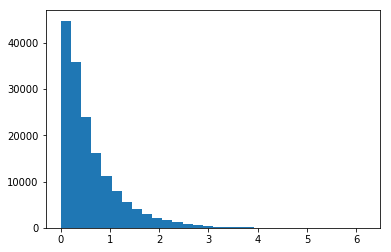

In [145]:
plt.hist(np.abs(combined_data["X_t-2"] - combined_data["X_t"]), bins=30)

In [154]:
exp_loc, exp_scale = expon.fit(np.abs(combined_data["X_t-1"] - combined_data["X_t"]), floc=0)
print(exp_loc, exp_scale)

0 0.298596191406


In [45]:
lorenz_series = xr.open_dataset("../exp/lorenz_output.nc")

In [61]:
x_values = lorenz_series["lorenz_x"][:, 0].to_dataframe()

In [91]:
lags = np.arange(5, 2001, 5)
auto_corr = np.zeros(lags.size)
for l, lag in enumerate(lags):
    auto_corr[l] = x_values["lorenz_x"].autocorr(lag)

In [94]:
auto_corr[:5]

array([ 0.99849999,  0.99401533,  0.98659175,  0.97630433,  0.96325586])

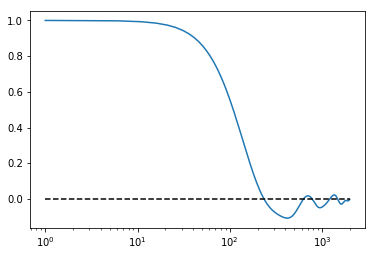

In [89]:
plt.plot(lags, auto_corr)
plt.plot(lags, np.zeros(lags.size), 'k--')
plt.gca().set_xscale("log")

In [114]:
x_values["lorenz_x"].values[1000::5]

array([ 7.35938501,  7.64667892,  7.96005154, ...,  2.92966819,
        3.04421759,  3.16192937])

(array([  3.30000000e+01,   2.04000000e+02,   1.23100000e+03,
          4.92500000e+03,   1.70230000e+04,   6.69190000e+04,
          7.71400000e+04,   1.08750000e+04,   1.51200000e+03,
          1.21000000e+02]),
 array([-8.38181484, -6.95794361, -5.53407238, -4.11020114, -2.68632991,
        -1.26245868,  0.16141255,  1.58528378,  3.00915501,  4.43302624,
         5.85689747]),
 <a list of 10 Patch objects>)

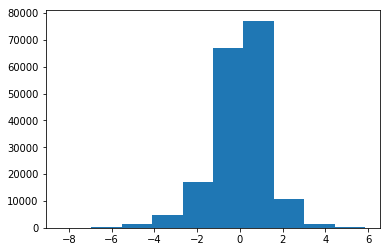

In [107]:
plt.hist(x_values["lorenz_x"].values[100:900015:5] - x_values["lorenz_x"].values[85:900000:5])

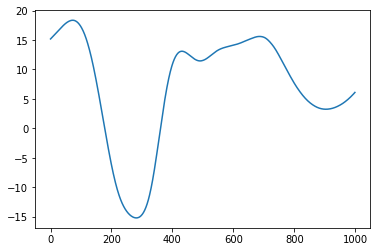

In [80]:
plt.plot(np.arange(1000), x_values.iloc[2000:3000, 1])

In [72]:
x_values.shape

(998001, 2)

(array([   126.,    180.,    565.,   1918.,   3632.,   7844.,  13770.,
         20660.,  29019.,  38926.,  47854.,  56198.,  64737.,  70152.,
         74519.,  79949.,  80543.,  74487.,  68967.,  57388.,  53141.,
         44603.,  37308.,  26730.,  19603.,  12166.,   8157.,   3743.,
           928.,    188.]),
 array([-3.3311972 , -3.12129442, -2.91139164, -2.70148886, -2.49158608,
        -2.2816833 , -2.07178052, -1.86187774, -1.65197496, -1.44207218,
        -1.2321694 , -1.02226662, -0.81236384, -0.60246106, -0.39255828,
        -0.1826555 ,  0.02724728,  0.23715006,  0.44705284,  0.65695562,
         0.8668584 ,  1.07676118,  1.28666396,  1.49656674,  1.70646952,
         1.9163723 ,  2.12627508,  2.33617786,  2.54608064,  2.75598342,
         2.9658862 ]),
 <a list of 30 Patch objects>)

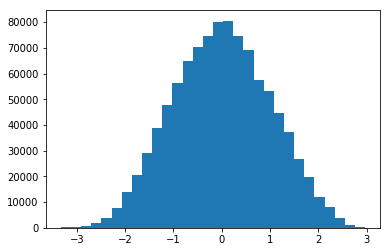

In [84]:
plt.hist((x_values["lorenz_x"] - x_values["lorenz_x"].mean()) / x_values['lorenz_x'].std(), 30)

In [115]:
all_x = lorenz_series["lorenz_x"].values

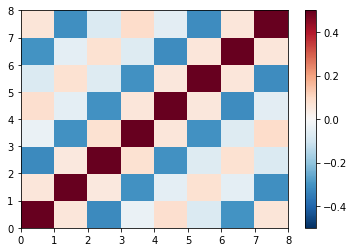

In [122]:
plt.pcolor(np.corrcoef(all_x.T), vmin=-0.5, vmax=0.5, cmap="RdBu_r")
plt.colorbar()

In [187]:
def fit_condition_distributions(train_cond_data):
    """
    Calculate the scale parameter for the exponential distribution of correlated conditional variables
    for the Lorenz 96 model in time.

    Args:
        train_cond_data: array of conditioning values where the first column is the current X, and each
            other column is a lagged X value

    Returns:
        array of scale values
    """
    train_cond_exp_scale = np.zeros(train_cond_data.shape[1] - 1)
    for i in range(1, train_cond_data.shape[1]):
        train_cond_exp_scale[i - 1] = expon.fit(np.abs(train_cond_data[:, 0] - train_cond_data[:, i]), floc=0)[1]
    return train_cond_exp_scale


def generate_random_condition_data(batch_size, num_cond_inputs, train_cond_scale):
    batch_cond_data = np.zeros((batch_size, num_cond_inputs, 1))
    batch_cond_data[:, 0, 0] = np.random.normal(size=batch_size)
    for t in range(1, train_cond_scale.size + 1):
        batch_cond_data[:, t , 0] = batch_cond_data[:, 0, 0] + \
                                    np.random.choice([-1, 1], size=batch_size) * expon.rvs(loc=0,
                                                                                           scale=train_cond_scale[t-1],
                                                                                           size=batch_size)
    return batch_cond_data

In [185]:
normed_x = (combined_data[x_cols] - combined_data[x_cols].mean()) / combined_data[x_cols].std()
normed_x = normed_x.values
print(normed_x.shape)

(159680, 3)


In [188]:
exp_scale = fit_condition_distributions(normed_x)
print(exp_scale)
batch_cond_data = generate_random_condition_data(128, 3, exp_scale)

[ 0.03906403  0.0780426 ]


In [86]:
rf = RandomForestRegressor(n_estimators=100, max_features="auto", max_depth=10)
rf.fit(combined_data[x_cols], combined_data[y_cols].mean(axis=1))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [87]:
out = rf.predict(combined_data[x_cols])

In [120]:
tree_preds = np.array([t.predict(combined_data[x_cols]) for t in rf.estimators_]).T

X_t      4.605129
X_t-1    4.347568
X_t-2    4.090302
Name: 0, dtype: float64


(array([  1.,   4.,   4.,  13.,  11.,  10.,   8.,   4.,  14.,  31.]),
 array([ 0.11398964,  0.12116318,  0.12833671,  0.13551025,  0.14268378,
         0.14985731,  0.15703085,  0.16420438,  0.17137792,  0.17855145,
         0.18572499]),
 <a list of 10 Patch objects>)

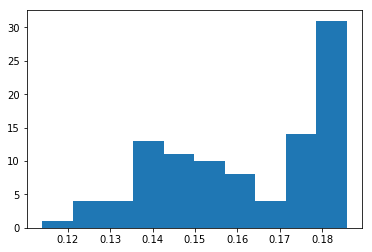

In [126]:
print(combined_data.loc[0, x_cols])
plt.hist(tree_preds[0])

(array([   2.,   11.,   53.,  114.,  227.,  261.,  196.,   97.,   30.,    9.]),
 array([ 0.15490953,  0.15617225,  0.15743498,  0.1586977 ,  0.15996042,
         0.16122315,  0.16248587,  0.1637486 ,  0.16501132,  0.16627404,
         0.16753677]),
 <a list of 10 Patch objects>)

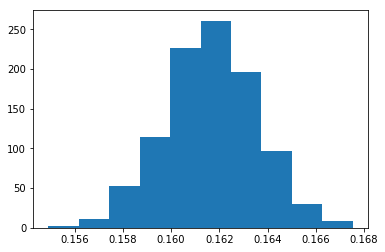

In [127]:
resampled_mean_preds = np.zeros(1000)
for i in range(1000):
    resampled_mean_preds[i] = np.random.choice(tree_preds[0], size=100, replace=True).mean()
plt.hist(resampled_mean_preds)

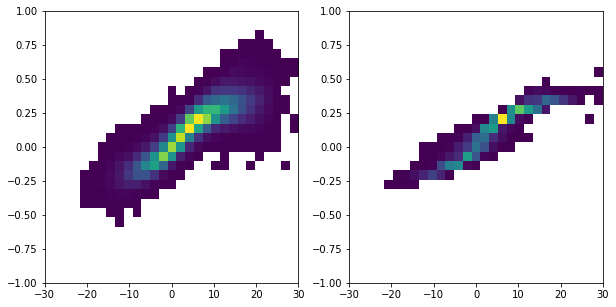

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = axes[0].hist2d(combined_data["X_t"], combined_data[y_cols].mean(axis=1), bins=[np.linspace(-30, 30, 30), 
                                                                                   np.linspace(-1, 1, 30)], cmin=1)
_ = axes[1].hist2d(combined_data["X_t"], out, bins=[np.linspace(-30, 30, 30), 
                                            np.linspace(-1, 1, 30)], cmin=1)

In [92]:
rf.feature_importances_

array([ 0.09937061,  0.00676902,  0.89386037])

(array([  2.00000000e+00,   8.10000000e+01,   6.68000000e+02,
          3.36100000e+03,   1.25160000e+04,   5.28510000e+04,
          7.90180000e+04,   1.00140000e+04,   1.11600000e+03,
          5.30000000e+01]),
 array([-6.18294001, -5.14881377, -4.11468754, -3.0805613 , -2.04643507,
        -1.01230884,  0.0218174 ,  1.05594363,  2.09006987,  3.1241961 ,
         4.15832233]),
 <a list of 10 Patch objects>)

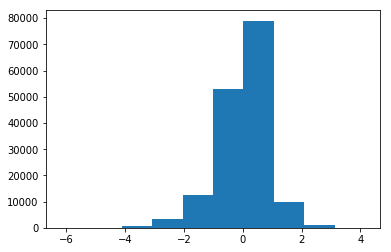

In [94]:
plt.hist(combined_data["X_t"] - combined_data["X_t-2"])

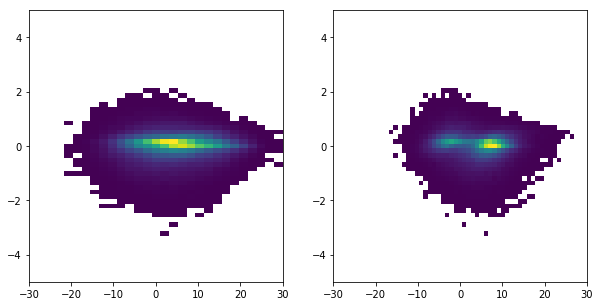

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = axes[0].hist2d(combined_data["X_t"], combined_data["X_t"] -combined_data["X_t-1"], bins=[np.linspace(-30, 30, 30), 
                                                                       np.linspace(-5, 5, 60)], cmin=1)
_ = axes[1].hist2d(combined_data[y_cols].sum(axis=1), combined_data["X_t"] - combined_data["X_t-1"], bins=[np.linspace(-30, 30, 60), 
                                                                       np.linspace(-5, 5, 60)], cmin=1)

In [115]:
lm = LinearRegression()
lm.fit(np.expand_dims(combined_data["X_t"].values, axis=-1), combined_data["X_t"] -combined_data["X_t-1"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [116]:
lm.coef_

array([ 0.00150673])